# Drug-molecule data

In [1]:
import numpy as np
from tdc.multi_pred import DTI
# https://tdcommons.ai/multi_pred_tasks/dti#davis
import pandas as pd

download_davis = DTI(name = 'DAVIS')
df_davis = download_davis.get_data()
split_davis = download_davis.get_split()
print("\nDAVIS dataset")
print("Number of drugs: ", len(df_davis['Drug'].unique()))
print("Number of proteins: ", len(df_davis['Target'].unique()))
print("Number of drug-target pairs: ", len(df_davis))

download_kiba = DTI(name = 'KIBA')
df_kiba = download_kiba.get_data()
split_kiba = download_kiba.get_split()
print("\nKIBA dataset")
print("Number of drugs: ", len(df_kiba['Drug'].unique()))
print("Number of proteins: ", len(df_kiba['Target'].unique()))
print("Number of drug-target pairs: ", len(df_kiba))

# collect all unique drugs and proteins from both datasets
drugs = np.unique(np.concatenate((df_davis['Drug'].unique(), df_kiba['Drug'].unique())))
targets = np.unique(np.concatenate((df_davis['Target'].unique(), df_kiba['Target'].unique())))
print("\nCombined dataset")
print("Number of drugs: ", len(drugs), " simply sum: ", len(df_davis['Drug'].unique()) + len(df_kiba['Drug'].unique()))
print("Number of proteins: ", len(targets), " simply sum: ", len(df_davis['Target'].unique()) + len(df_kiba['Target'].unique()))

Found local copy...
Loading...
Done!
Found local copy...
Loading...



DAVIS dataset
Number of drugs:  68
Number of proteins:  379
Number of drug-target pairs:  25772


Done!



KIBA dataset
Number of drugs:  2068
Number of proteins:  229
Number of drug-target pairs:  117657

Combined dataset
Number of drugs:  2127  simply sum:  2136
Number of proteins:  429  simply sum:  608


Longest drug:  532
Longest protein:  4128
Average drug length:  49.77433004231312
Average protein length:  746.1351981351982


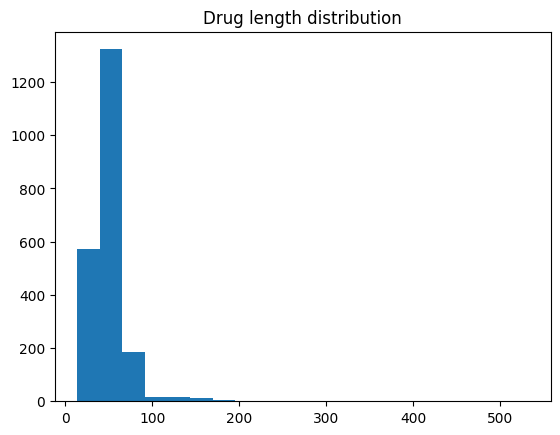

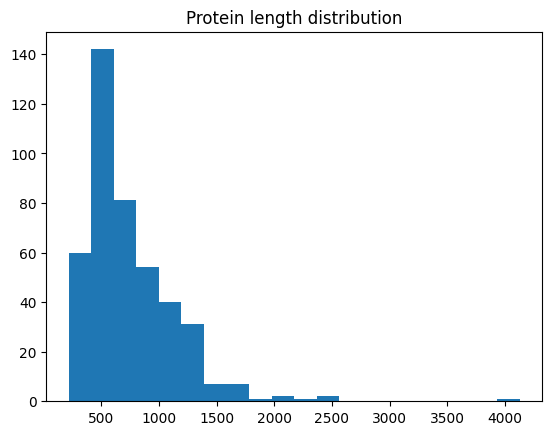

In [2]:
# get the lenght of the longest drug and protein
max_drug = max([len(drug) for drug in drugs])
max_target = max([len(target) for target in targets])
print("Longest drug: ", max_drug)
print("Longest protein: ", max_target)

# get the average length of drugs and proteins
avg_drug = np.mean([len(drug) for drug in drugs])
avg_target = np.mean([len(target) for target in targets])
print("Average drug length: ", avg_drug)
print("Average protein length: ", avg_target)

# get the distribution of drug and protein lengths in a histogram
import matplotlib.pyplot as plt
plt.hist([len(drug) for drug in drugs], bins=20)
plt.title("Drug length distribution")
plt.show()
plt.hist([len(target) for target in targets], bins=20)
plt.title("Protein length distribution")
plt.show()

Longest drug:  532
Longest protein:  4128
Average drug length:  49.77433004231312
Average protein length:  746.1351981351982


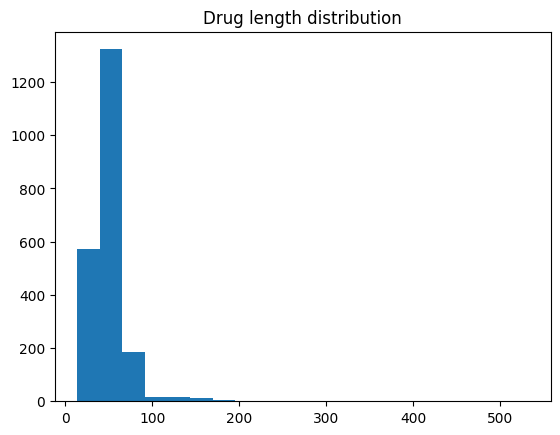

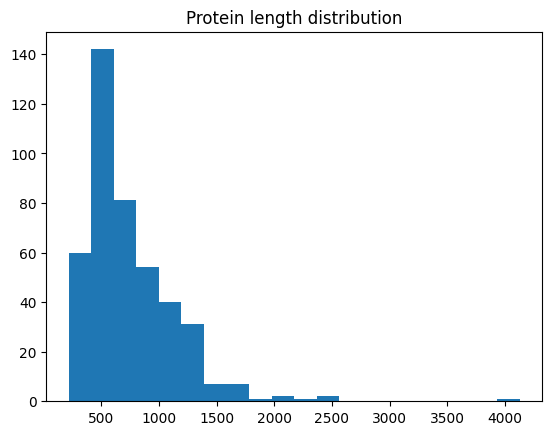

In [3]:
# get the lenght of the longest drug and protein
max_drug = max([len(drug) for drug in drugs])
max_target = max([len(target) for target in targets])
print("Longest drug: ", max_drug)
print("Longest protein: ", max_target)

# get the average length of drugs and proteins
avg_drug = np.mean([len(drug) for drug in drugs])
avg_target = np.mean([len(target) for target in targets])
print("Average drug length: ", avg_drug)
print("Average protein length: ", avg_target)

# get the distribution of drug and protein lengths in a histogram
import matplotlib.pyplot as plt
plt.hist([len(drug) for drug in drugs], bins=20)
plt.title("Drug length distribution")
plt.show()
plt.hist([len(target) for target in targets], bins=20)
plt.title("Protein length distribution")
plt.show()

Longest drug:  532
Longest protein:  4128
Average drug length:  49.77433004231312
Average protein length:  746.1351981351982


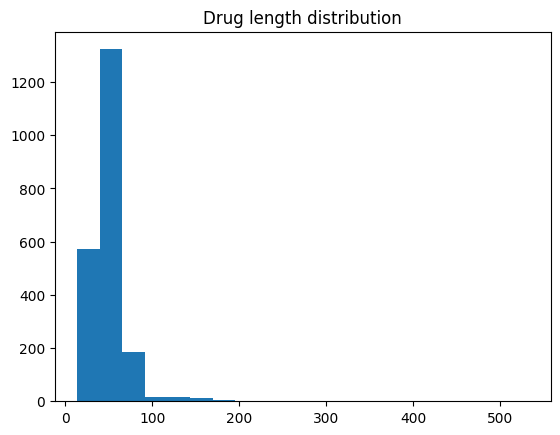

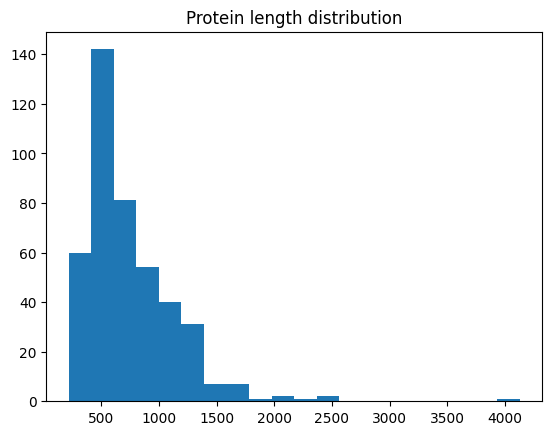

In [4]:
# get the lenght of the longest drug and protein
max_drug = max([len(drug) for drug in drugs])
max_target = max([len(target) for target in targets])
print("Longest drug: ", max_drug)
print("Longest protein: ", max_target)

# get the average length of drugs and proteins
avg_drug = np.mean([len(drug) for drug in drugs])
avg_target = np.mean([len(target) for target in targets])
print("Average drug length: ", avg_drug)
print("Average protein length: ", avg_target)

# get the distribution of drug and protein lengths in a histogram
import matplotlib.pyplot as plt
plt.hist([len(drug) for drug in drugs], bins=20)
plt.title("Drug length distribution")
plt.show()
plt.hist([len(target) for target in targets], bins=20)
plt.title("Protein length distribution")
plt.show()


---
---

# Encoding drug-molecules

Molecules in SMILES fromat are embedded through 3 views: MolGraph, Image, SMILES

See
 - https://github.com/BiomedSciAI/biomed-multi-view
 - https://huggingface.co/ibm/biomed.sm.mv-te-84m

In [5]:
from model import BiomedMultiViewEncoder

some_smiles = drugs[:10]

drug_encoder_model = BiomedMultiViewEncoder() # 8M parameters
graph_emb, image_emb, text_emb = drug_encoder_model(some_smiles)
print("Graph embeddings shape: ", graph_emb.shape)
print("Image embeddings shape: ", image_emb.shape)
print("Text embeddings shape: ", text_emb.shape)

2024-11-09 23:41:10,644 - rdkit - INFO - pop-os:128118516662016:0:0 - Enabling RDKit 2023.09.6 jupyter extensions
2024-11-09 23:41:11,663 - root - INFO - pop-os:128118516662016:0:0 - Using DTI-VAE architecture for aggregator
2024-11-09 23:41:11,664 - root - INFO - pop-os:128118516662016:0:0 - dim_list [512, 512, 768] of Graph2dModel, ImageModel, TextModel
2024-11-09 23:41:11,678 - root - INFO - pop-os:128118516662016:0:0 - Loading checkpoint from provided path ../data_root/bmfm_model_dir/pretrained/MULTIVIEW_MODEL/biomed-smmv-with-coeff-agg.pth
2024-11-09 23:41:11,836 - root - INFO - pop-os:128118516662016:0:0 - Loading pretrain checkpoint for SmallMoleculeMultiView Model - <All keys matched successfully>


Graph embeddings shape:  torch.Size([10, 512])
Image embeddings shape:  torch.Size([10, 512])
Text embeddings shape:  torch.Size([10, 768])


In [6]:
from model import MoleculeVAEAggregator

drug_vae_model = MoleculeVAEAggregator(mlp_layers=2, latent_dim=512) # 5M paramters (basic agg is 2M)

decoded, z, coeffs = drug_vae_model((graph_emb, image_emb, text_emb))
print(z.shape)
print(coeffs.shape)
print(coeffs)
for item in decoded:
    print(item.shape)

torch.Size([10, 512])
torch.Size([3])
tensor([0.3439, 0.3222, 0.3339], grad_fn=<SelectBackward0>)
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 768])


---
---

# Encoding target-proteins

Proteins in amino-acid sequence format are embedded through 1 view: amino-acid sequence

See
 - https://github.com/mheinzinger/ProstT5
 - https://huggingface.co/Rostlab/ProstT5

In [2]:
torch.cuda.is_available()

True

In [8]:
import re
from transformers import T5Tokenizer, T5EncoderModel
import torch
# https://huggingface.co/Rostlab/ProstT5

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Load the tokenizer & model (local of HF)
tokenizer = T5Tokenizer.from_pretrained('../data_root/ProstT5_model_dir', do_lower_case=False)
model_protein = T5EncoderModel.from_pretrained("../data_root/ProstT5_model_dir").to(device)
# tokenizer = T5Tokenizer.from_pretrained('Rostlab/ProstT5', do_lower_case=False).to(device)
# model = T5EncoderModel.from_pretrained("Rostlab/ProstT5").to(device)

# only GPUs support half-precision (float16) currently; if you want to run on CPU use full-precision (float32) (not recommended, much slower)
model_protein.float() if device.type=='cpu' else model_protein.half()
model_protein.dtype

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


torch.float32

In [9]:
model_protein

T5EncoderModel(
  (shared): Embedding(150, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(150, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dropout): Dropo

In [10]:
# prepare your protein sequences/structures as a list of upper-case amino acid sequences
some_sequences = [
    "MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV",
    "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLP",
    "MVLGTVLLPPNSYGRDQDTSLCCLCTEA",
    "MVDGVMILPVLIMIALP",
    "MGAAAKLAFA",
]
# replace all rare/ambiguous amino acids by X and introduce white-space between all sequences
sequences = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))).upper() for sequence in some_sequences]

# indicate the direction of the translation by prepending "<AA2fold>" if you go from 3Di to AAs (or if you want to embed AAs)
sequences = ["<AA2fold>" + " " + s for s in sequences]

# tokenize sequences and pad up to the longest sequence in the batch
ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest", return_tensors='pt').to(device)


# generate embeddings
with torch.no_grad():
    embeddings_rpr = model_protein(ids.input_ids,  attention_mask=ids.attention_mask).last_hidden_state
print("Batch embedding: ", embeddings_rpr.shape, "\n")

# remove the special first token
embeddings = []
for i in range(embeddings_rpr.shape[0]):
    l = len(some_sequences[i])
    subseq = embeddings_rpr[i, 1:l+1]
    print("Subsequence embedding: ", subseq.shape)
    mean_subseq = subseq.mean(dim=0)
    print("Mean subsequence embedding: ", mean_subseq.shape, "\n")
    embeddings.append(mean_subseq)

Batch embedding:  torch.Size([5, 48, 1024]) 

Subsequence embedding:  torch.Size([46, 1024])
Mean subsequence embedding:  torch.Size([1024]) 

Subsequence embedding:  torch.Size([36, 1024])
Mean subsequence embedding:  torch.Size([1024]) 

Subsequence embedding:  torch.Size([28, 1024])
Mean subsequence embedding:  torch.Size([1024]) 

Subsequence embedding:  torch.Size([17, 1024])
Mean subsequence embedding:  torch.Size([1024]) 

Subsequence embedding:  torch.Size([10, 1024])
Mean subsequence embedding:  torch.Size([1024]) 



In [13]:
for emb in embeddings:
    print(emb.shape)

torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])


In [16]:
import torch

torch.stack(embeddings, dim=0).shape

torch.Size([5, 1024])

---
---

In [75]:
model_molecule

SmallMoleculeMultiView(
  (model_graph): Graph2dModel(
    (graph_encoder): Graph2dEncoder(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (graph_feature): GraphFeatureTokenizer(
        (atom_encoder): Embedding(4608, 512, padding_idx=0)
        (edge_encoder): Embedding(1536, 512, padding_idx=0)
        (graph_token): Embedding(1, 512)
        (null_token): Embedding(1, 512)
        (lap_encoder): Linear(in_features=32, out_features=512, bias=False)
        (lap_eig_dropout): Dropout2d(p=0.2, inplace=False)
        (order_encoder): Embedding(2, 512)
      )
      (emb_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x Graph2dEncoderLayer(
          (dropout_module): Dropout(p=0.0, inplace=False)
          (self_attn): MultiheadAttention(
            (attention_dropout_module): Dropout(p=0.1, inplace=False)
            (dropout_m

In [76]:
model_protein

T5EncoderModel(
  (shared): Embedding(150, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(150, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dropout): Dropo